## Decide whether network is predicting depth or disparity

In [1]:
import os
import numpy as np
import torch
import cv2
from torchvision.transforms import Compose
import matplotlib.pyplot as plt

from dpt.models import DPTDepthModel
from dpt.transforms import Resize, NormalizeImage, PrepareForNet
from data.InteriorNetDataset import InteriorNetDataset

In [2]:
torch.manual_seed(0)
np.random.seed(0)

# k8s paths
k8s = True
k8s_repo = r'opt/repo/dynamic-inference'
k8s_pvc = r'christh9-pvc'

# path settings
input_path = 'input'
output_path = 'output_monodepth'
model_path = 'weights/dpt_hybrid_nyu-2ce69ec7.pt'
dataset_path = 'video_inference_common/resources'
logs_path = 'train-logs'

if k8s:
    input_path = os.path.join(k8s_repo, input_path)
    output_path = os.path.join(k8s_repo, output_path)
    model_path = os.path.join(k8s_pvc, 'dpt-hybrid-nyu.pt')
#     model_path = os.path.join(k8s_pvc, 'train-logs', 'finetune7.pt')
    dataset_path = os.path.join(k8s_repo, dataset_path)
    logs_dir = os.path.join(k8s_pvc, logs_path)

os.chdir('/')

In [3]:
optimize = False
net_w = 640
net_h = 480
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
model = DPTDepthModel(
            path=model_path,
            scale=0.000305,
            shift=0.1378,
            invert=True,
            backbone="vitb_rn50_384",
            non_negative=True,
            enable_attention_hooks=False,
        )

normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

transform = Compose(
        [
            Resize(
                net_w,
                net_h,
                resize_target=None,
                keep_aspect_ratio=True,
                ensure_multiple_of=32,
                resize_method="minimal",
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            normalization,
            PrepareForNet(),
        ]
    )

model.eval()

if optimize == True and device == torch.device("cuda"):
    model = model.to(memory_format=torch.channels_last)
    model = model.half()

model.to(device)
print('Loaded model')

Loaded model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


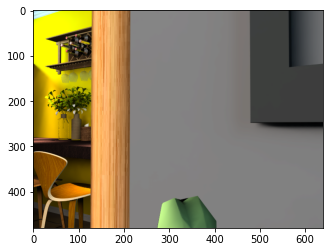

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([1, 480, 640])


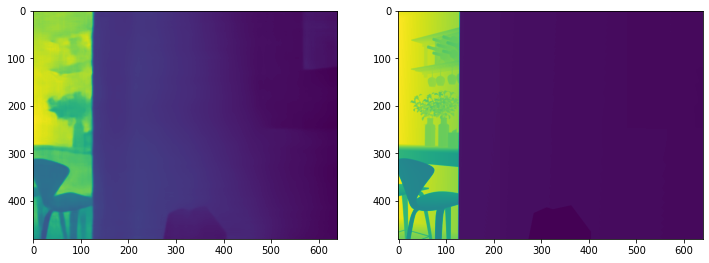

In [5]:
interiornet_dataset = InteriorNetDataset(dataset_path, transform=transform, subsample=True)

with torch.no_grad():
    batch = interiornet_dataset[0]
    img, depth = batch['image'], batch['depth']

    plt.imshow(np.moveaxis(img,0,2))
    plt.show()

    sample = torch.from_numpy(img).to(device).unsqueeze(0)

    if optimize == True and device == torch.device("cuda"):
        sample = sample.to(memory_format=torch.channels_last)
        sample = sample.half()

    prediction = model.forward(sample)
    print(prediction.shape)
    prediction = (
        torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[1:],
            mode="bicubic",
            align_corners=False,
        )
        .squeeze()
        .cpu()
    )

    fig, axs = plt.subplots(1,2, figsize=(12,12))
    axs[0].imshow(prediction.cpu())
    axs[1].imshow(depth)
    
    plt.show()

## Compute scale/shift for networks

In [6]:
import os
import torch
import numpy as np

from dpt.models import DPTDepthModel
from dpt.transforms import Resize, NormalizeImage, PrepareForNet
from data.InteriorNetDataset import InteriorNetDataset

from util.validate_nyu import BadPixelMetric

ModuleNotFoundError: No module named 'h5py'